In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,  MaxPooling2D, Input, Conv2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import cv2

Data Loading

In [26]:
# load the data
main_folder_path = "/Users/liqi/Desktop/23AUTUMNSEM/FYP/Korean"
# create a variable to store the image and label data
image_data = []
labels = []

In [27]:
# define a function to process the images
def process_images(folder_path):
    # loop through all the files in the folder
    for filename in os.listdir(folder_path):
        # check if the file is a jpg file
        if filename.endswith(".jpg"):
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)
            grayscale_img = img.convert('L')  
            resized_img = grayscale_img.resize((64, 64))
            image_data.append(list(resized_img.getdata()))
            labels.append(filename.split('_')[0])

In [28]:
# call the function to process the images
process_images(main_folder_path)

In [29]:
# convert the image data and labels to numpy arrays
columns = [f"pixel_{i}" for i in range(len(image_data[0]))] 
# create a dataframe
df = pd.DataFrame(image_data, columns=columns)
# add the labels to the dataframe
df['label'] = labels

In [30]:
df.to_csv('hangul_dataset.csv', index=False)

In [31]:
print(df.head())

   pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0      254      254      254      254      254      254      254      254   
1      255      255      255      255      253      251      252      254   
2      252      252      249      248      251      255      255      255   
3      255      255      255      255      255      255      255      255   
4      251      251      253      255      255      254      250      244   

   pixel_8  pixel_9  ...  pixel_4087  pixel_4088  pixel_4089  pixel_4090  \
0      254      254  ...         255         255         255         255   
1      255      255  ...         255         255         255         255   
2      255      255  ...         255         255         255         255   
3      255      255  ...         253         255         255         255   
4      244      251  ...         255         255         255         255   

   pixel_4091  pixel_4092  pixel_4093  pixel_4094  pixel_4095  label  
0        

In [32]:
df.shape

(2400, 4097)

EDA & Preprocessing

In [33]:
# check for missing values
df.iloc[:, :-1] = df.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')

In [34]:
# label encoding
le = LabelEncoder()
encoded = le.fit_transform(df['label'].values)
decoded = le.inverse_transform(encoded)
df['label2'] = encoded
print('The dataset has the following labels: ', le.classes_)

The dataset has the following labels:  ['a' 'ae' 'b' 'bb' 'ch' 'd' 'e' 'eo' 'eu' 'g' 'gg' 'h' 'i' 'j' 'k' 'm' 'n'
 'ng' 'o' 'p' 'r' 's' 'ss' 't' 'u' 'ya' 'yae' 'ye' 'yo' 'yu']


In [35]:
classes = le.classes_

In [36]:
dic={0:'a',1:'ae',2:'b',3:'bb',4:'ch',5:'d',6:'e',7:'eo',8:'eu',9:'g',10:'gg',11:'h',12:'i',
     13:'j',14:'k', 15:'m',16:'n', 17:'ng', 18:'o', 19: 'p', 20: 'r', 21: 's', 22: 'ss', 23:'t', 
     24: 'u', 25:'ya', 26:'yae', 27:'ye', 28: 'yo', 29: 'yu'}

In [37]:
df.shape

(2400, 4098)

Train-test split

In [38]:
X =df.iloc[:,0:4096]
y =df.iloc[:,[4097]]
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4)

In [39]:
# reshape the data
X_train = X_train.astype('float32')/255
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')/255
y_test = y_test.astype('float32')

In [40]:
# one-hot encode the labels
X_train= X_train.to_numpy()
y_train= y_train.to_numpy()
X_test= X_test.to_numpy()
y_test= y_test.to_numpy()

# reshape train data and test data into 64 * 64 * 1
X_train = X_train.reshape(X_train.shape[0], 64, 64, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 64, 64, 1).astype('float32')

In [41]:
y_train = to_categorical(y_train, 30)
y_test = to_categorical(y_test, 30)
num_classes = y_train.shape[1]
num_classes

30

In [42]:
# image data augmentation
datagen = ImageDataGenerator(
         width_shift_range=0.01,
         height_shift_range=0.01,
         shear_range=0.1,
         zoom_range=0.1,
)

train_generator = datagen.flow(X_train, y_train, batch_size=64)
test_generator = datagen.flow(X_test, y_test, batch_size=64, shuffle=False)

In [43]:
# learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    decay_factor=0.5
    decay_epochs=5
    return initial_lr * (decay_factor ** np.floor(epoch/decay_epochs))

lr_scheduler = LearningRateScheduler(lr_schedule)

 Model building¶

Basic CNN model

In [44]:
# model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        832       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 28800)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3686528   
                                                                 
 dense_5 (Dense)             (None, 30)                3870      
                                                                 
Total params: 3691230 (14.08 MB)
Trainable params: 3691230 (14.08 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [45]:
# fit the model
model1 = model.fit(train_generator, steps_per_epoch=len(X_train) // 64, 
                   epochs=20, validation_data=test_generator, validation_steps=len(X_test)//64,callbacks=[lr_scheduler])

Epoch 1/20


22/22 [==============================] - 3s 117ms/step - loss: 3.4916 - accuracy: 0.0698 - val_loss: 3.1800 - val_accuracy: 0.1688 - lr: 0.0010
Epoch 2/20
22/22 [==============================] - 2s 90ms/step - loss: 2.9245 - accuracy: 0.2587 - val_loss: 2.6061 - val_accuracy: 0.3031 - lr: 0.0010
Epoch 3/20
22/22 [==============================] - 2s 87ms/step - loss: 2.2172 - accuracy: 0.4201 - val_loss: 1.8769 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 4/20
22/22 [==============================] - 2s 79ms/step - loss: 1.4823 - accuracy: 0.6193 - val_loss: 1.3232 - val_accuracy: 0.6510 - lr: 0.0010
Epoch 5/20
22/22 [==============================] - 2s 94ms/step - loss: 0.9971 - accuracy: 0.7238 - val_loss: 1.0344 - val_accuracy: 0.7104 - lr: 0.0010
Epoch 6/20
22/22 [==============================] - 2s 84ms/step - loss: 0.7330 - accuracy: 0.8089 - val_loss: 0.8618 - val_accuracy: 0.7740 - lr: 5.0000e-04
Epoch 7/20
22/22 [==============================] - 2s 88ms/step - loss: 0.6563 - 

In [46]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')

30/30 [==============================] - 0s 9ms/step - loss: 0.4286 - accuracy: 0.8896
Test Loss: 0.4286452829837799
Test Accuracy: 88.96%


Base model loss and accuracy

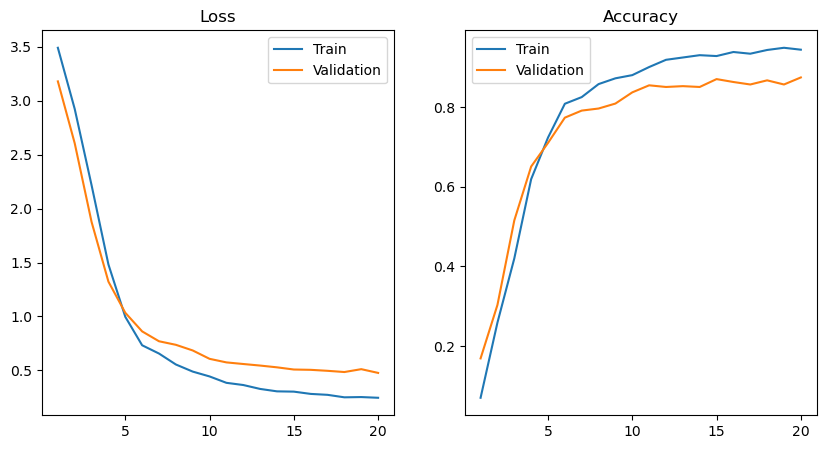

In [47]:
start = 1
end = 20

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(start,end+1), model1.history['loss'][start-1:end], label='Train')
axes[0].plot(range(start,end+1), model1.history['val_loss'][start-1:end], label='Validation')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(range(start,end+1), model1.history['accuracy'][start-1:end], label='Train')
axes[1].plot(range(start,end+1), model1.history['val_accuracy'][start-1:end], label='Validation')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.show()

Base model's confusion matrix

30/30 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        32
           1       0.84      0.84      0.84        32
           2       0.91      1.00      0.96        32
           3       1.00      0.88      0.93        32
           4       0.97      0.88      0.92        32
           5       0.88      0.91      0.89        32
           6       0.94      0.94      0.94        32
           7       0.84      0.84      0.84        32
           8       0.83      0.94      0.88        32
           9       0.97      0.91      0.94        32
          10       0.94      0.94      0.94        32
          11       0.81      0.78      0.79        32
          12       0.90      0.88      0.89        32
          13       0.94      0.91      0.92        32
          14       0.91      0.97      0.94        32
          15       1.00      0.91      0.95        32
          16       0.90     

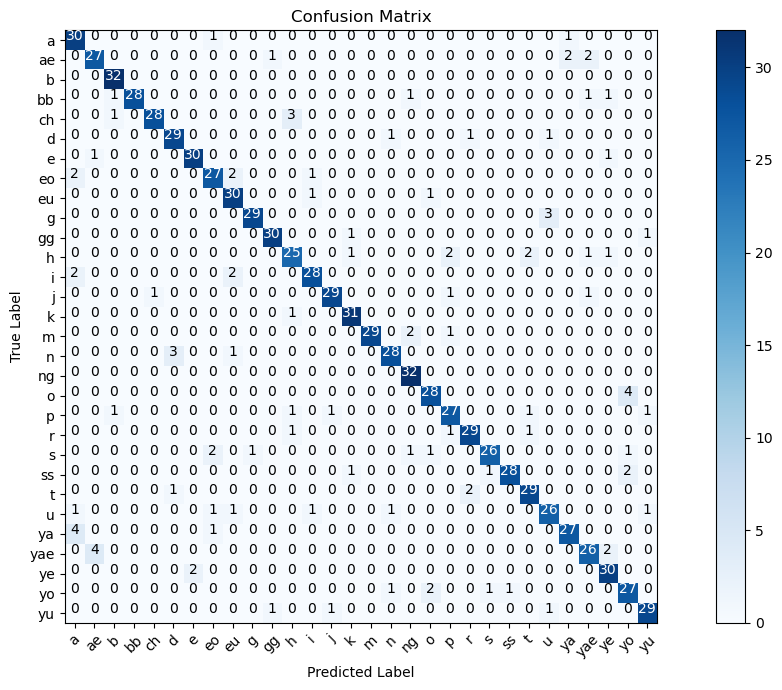

In [48]:
y_pred = model.predict(X_test)
y_true = y_test 

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

print(classification_report(y_true_labels, y_pred_labels))

plt.figure(figsize=(12, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
plt.show()

Hyperparam tuning

In [50]:
# define the hypermodel
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(64, 64, 1))) 
    
    for i in range(hp.Int('num_conv_layers', min_value=1, max_value=5)):
        model.add(Conv2D(
            filters=hp.Int(f'conv_{i}_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Int(f'conv_{i}_kernel', min_value=3, max_value=7),
            activation='relu',
            padding='same'
        ))
        model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=512, step=32),
        activation='relu'
    ))
    model.add(Dense(num_classes, activation='softmax'))  
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [51]:
# instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  
    max_trials=15,
    directory='model_tuning',  
    project_name='korean_tuning' 
)
# early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# search for the best hyperparameters
tuner.search(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=35,
    callbacks=[early_stopping]
)

Reloading Tuner from model_tuning/korean_tuning/tuner0.json


In [52]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = build_model(best_hps)

In [54]:
history = best_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
45/45 [==============================] - 21s 466ms/step - loss: 3.3810 - accuracy: 0.0333 - val_loss: 2.9649 - val_accuracy: 0.1302
Epoch 2/30
45/45 [==============================] - 20s 451ms/step - loss: 1.9515 - accuracy: 0.3965 - val_loss: 1.3817 - val_accuracy: 0.5083
Epoch 3/30
45/45 [==============================] - 19s 431ms/step - loss: 0.9344 - accuracy: 0.6694 - val_loss: 0.6325 - val_accuracy: 0.7531
Epoch 4/30
45/45 [==============================] - 18s 413ms/step - loss: 0.4590 - accuracy: 0.8285 - val_loss: 0.4582 - val_accuracy: 0.8365
Epoch 5/30
45/45 [==============================] - 21s 476ms/step - loss: 0.2074 - accuracy: 0.9146 - val_loss: 0.3225 - val_accuracy: 0.8896
Epoch 6/30
45/45 [==============================] - 19s 433ms/step - loss: 0.1596 - accuracy: 0.9472 - val_loss: 0.3509 - val_accuracy: 0.8875
Epoch 7/30
45/45 [==============================] - 21s 465ms/step - loss: 0.1355 - accuracy: 0.9514 - val_loss: 0.1580 - val_accuracy: 0.9531

In [55]:
# Evaluate the model
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')

30/30 [==============================] - 5s 163ms/step - loss: 0.1090 - accuracy: 0.9812
Test Loss: 0.10897793620824814
Test Accuracy: 98.12%


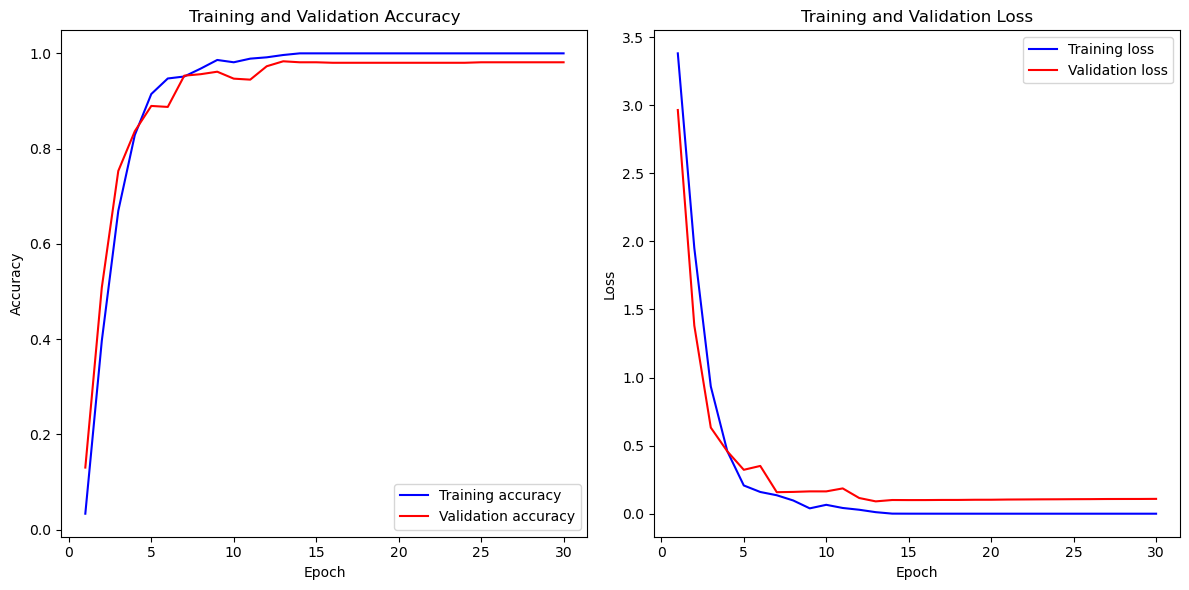

In [56]:
#Loss Curves
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the model.fit() method
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

30/30 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        32
           1       0.84      0.84      0.84        32
           2       0.91      1.00      0.96        32
           3       1.00      0.88      0.93        32
           4       0.97      0.88      0.92        32
           5       0.88      0.91      0.89        32
           6       0.94      0.94      0.94        32
           7       0.84      0.84      0.84        32
           8       0.83      0.94      0.88        32
           9       0.97      0.91      0.94        32
          10       0.94      0.94      0.94        32
          11       0.81      0.78      0.79        32
          12       0.90      0.88      0.89        32
          13       0.94      0.91      0.92        32
          14       0.91      0.97      0.94        32
          15       1.00      0.91      0.95        32
          16       0.90    

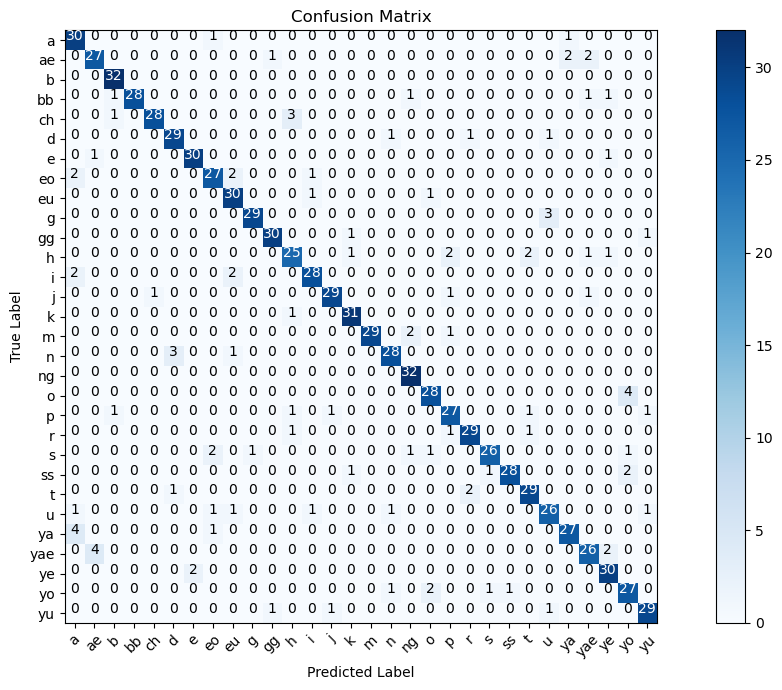

In [57]:
y_pred = model.predict(X_test)
y_true = y_test 

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

print(classification_report(y_true_labels, y_pred_labels))

plt.figure(figsize=(12, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
plt.show()

In [58]:
# Save the model
best_model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/korean_best_model')

INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/korean_best_model/assets


INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/korean_best_model/assets


In [59]:
print(best_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 96)        3552      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 96)        230496    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        153664    
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 8, 8, 64)         